# Beating the Zestimate® | Predicting Home Values
Stephanie N. Jones<br>
Junior Data Scientist | Zillow Data Science Team<br>
Monday, December 13, 2021

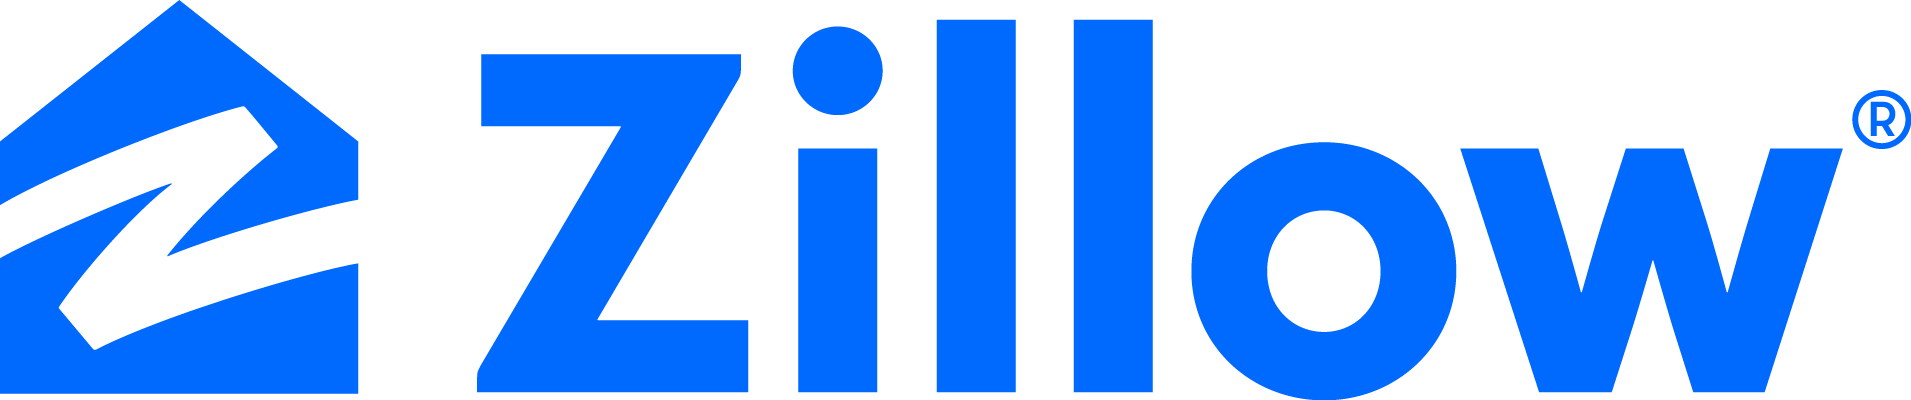

## Business Goals
<hr>

### Primary Goal #1 | Predict Home Values
Construct Machine Learning model by finding key drivers that predicts property tax assessed values <b>`taxvaluedollarcnt`</b> of Single Family Properties with transactions during 2017

### Primary Goal #2 | Beat Zestimate®
Improve existing Zillow model for predicting home values 

### Secondary Goal | Property Locations
City and state of each property

## Executive Summary
<hr>

### Initial Questions
>Does size affect housing price?<br>
Do more bredrooms = higher cost?<br>
Do more bathrooms = higher cost?<br>
What affects housing price more between sqft, beds, and baths?

### Initial Hypothesis
>Bigger size (in sqft) has the greatest impact on housing price.

### Conclusions
>Key findings:
- sqft - highest impact
- prices evenly distributed across counties
- baths > beds

### 01 Acquire
<hr>

- include: env instructions for url string, sql query, etc.
- contents

### SQL query
`SELECT bathroomcnt,
        bedroomcnt,
        calculatedfinishedsquarefeet,
        fips,
        yearbuilt,
        taxvaluedollarcnt
FROM properties_2017
JOIN predictions_2017 USING(parcelid)
WHERE propertylandusetypeid = 261;`

### 02 Prepare
<hr>

### Columns included to prepare data for exploration and modeling
`baths` <br>
`beds` <br>
`sqft` <br>
`fips` <br>
`yearbuilt` <br>
`tax_value`


# Outliers...
- `beds`
- `baths`
- `sqft`
- `tax_value`

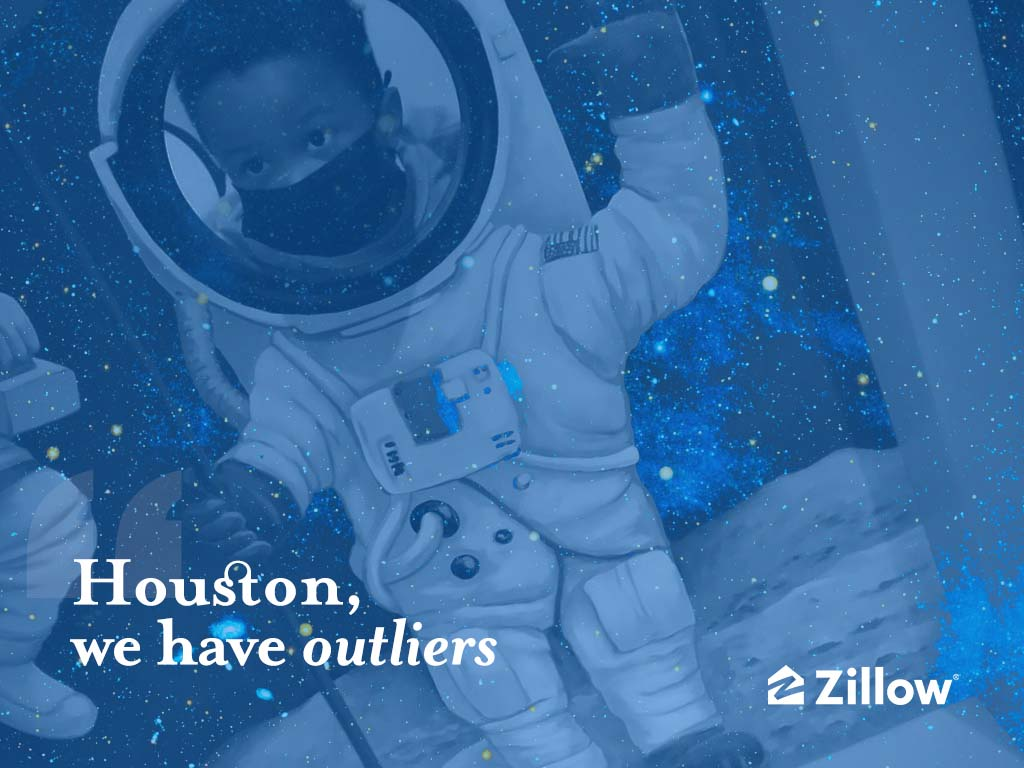


### More box, less dots.
<hr>

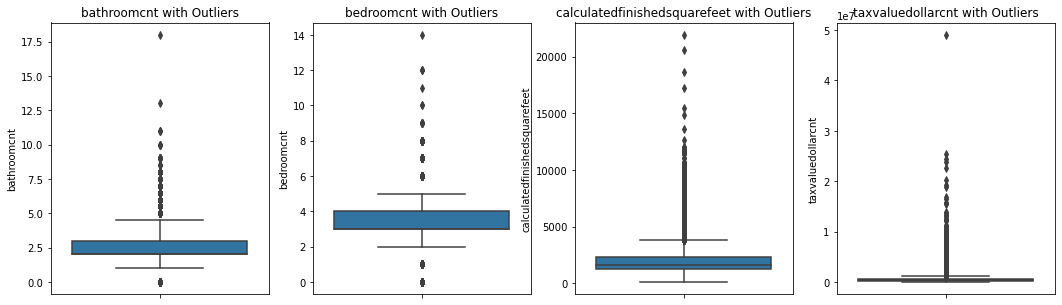

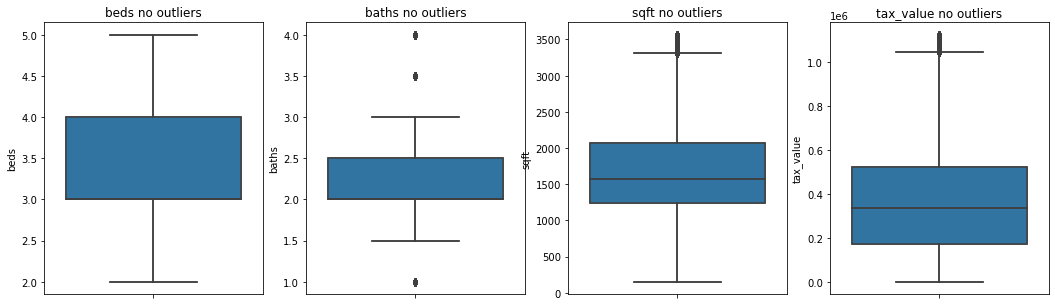

In [3]:
wrangle.visualize_data()

# Prepared for Exploration and Modeling
<hr>


### Dropped NA
### Dropped 0 `beds` and 0 `baths`
### Encoded  `fips`

In [1]:
import wrangle

df = wrangle.clean_data()

In [2]:
df.head()

,baths,beds,sqft,fips,yearbuilt,tax_value
0,3.5,4.0,3100.0,6059.0,1998.0,1023282.0
1,1.0,2.0,1465.0,6111.0,1967.0,464000.0
2,2.0,3.0,1243.0,6059.0,1962.0,564778.0
3,3.0,4.0,2376.0,6037.0,1970.0,145143.0
4,3.0,4.0,2962.0,6037.0,1950.0,773303.0


In [38]:
import matplotlib.pyplot as plt

(wrangle.clean_data()).tax_value.min()

1000.0

# Next...
>Split and Explore...

### 03 Explore
<hr>

#### Questions
- Do certain counties have higher tax values as sqft increases?
- Do certain counties have more beds? baths?
- Does bedroom count or bathroom count have the greater impact on home value? 

## Initial Hypothesis
> <b>Bigger houses are more expensive</b>

In [4]:
import wrangle
import explore

df = wrangle.prepare_data()

In [5]:
train, validate, test = wrangle.prepare_data()

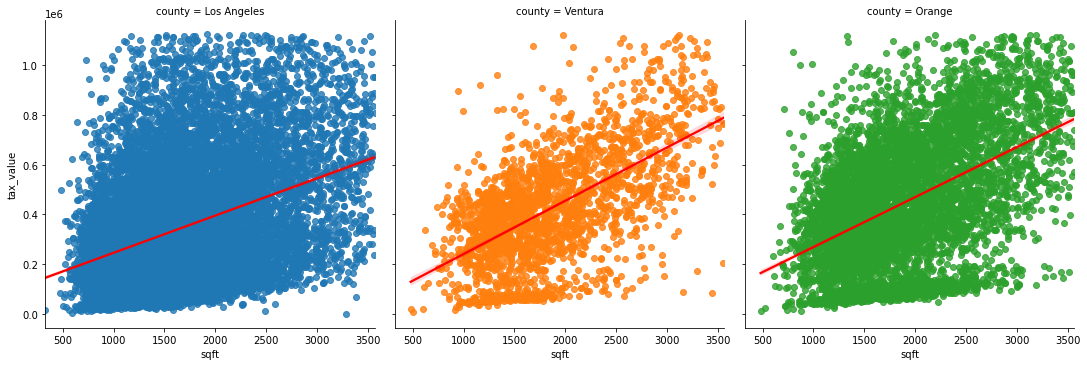

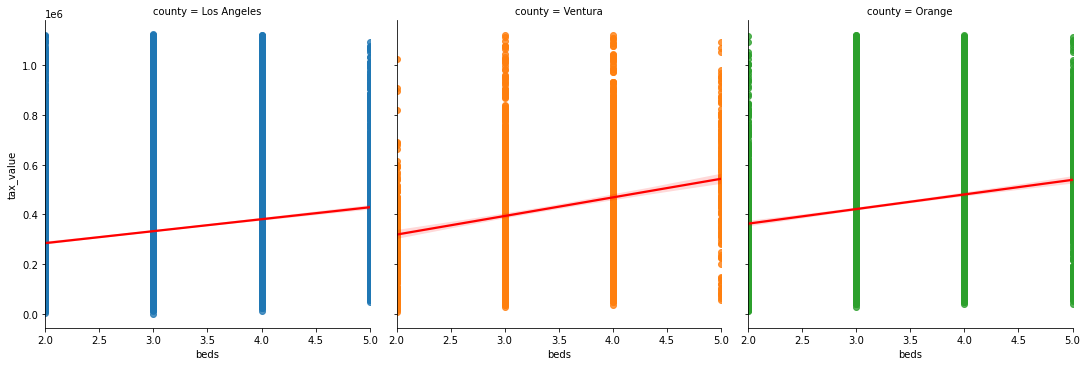

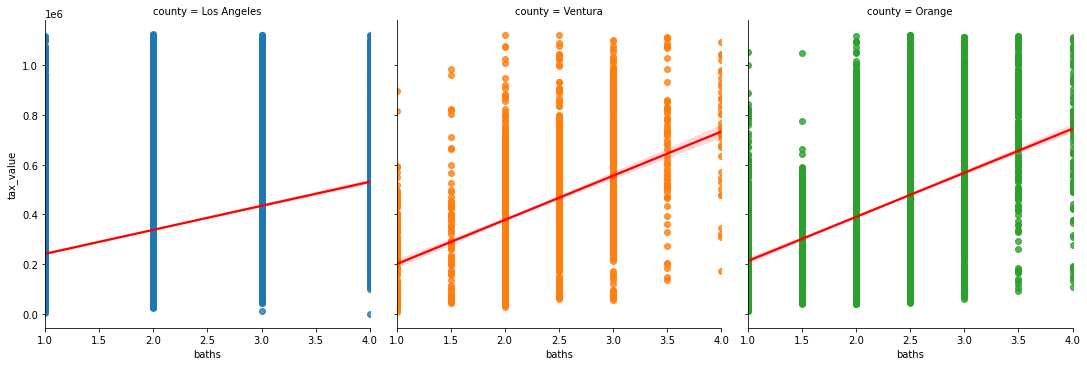

In [6]:
explore.explore_data(train)

### Results from Correlation Tests
>H(o): There is <b>no correlation</b> between home size (sqft) and home price (tax_value)<br>
H(a): There is a correlation between home size (sqft) and home price (tax_value)<br>
<br>

>H(o): Bedroom count affects home price more than bathroom count.<br>
H(a): Bedroom count <b>does not </b>affect home price more than bathroom count.

In [7]:
corr_sqft, corr_beds, corr_baths = explore.test_data(train)

In [8]:
print(f'Sqft: {corr_sqft}')
print(f'Beds: {corr_beds}')
print(f'Baths: {corr_baths}')

Sqft: 0.44896180188866014
Beds: 0.19901900770221143
Baths: 0.37386120065145123


## Key Takeaways from Explore

### Do certain counties have higher sqft as tax value increases?
>Each county is close to the same in terms of sqft increasing w/home value
- Do certain counties have more beds? baths?
> Ventura county has more beds and bath centrally distributed<br>
> Other two counties have about same number of beds and baths
- Does bedroom count or bathroom count have the greater impact on home value? 
> Sqft has the greatest impact on home value, followed by bathroom count, and then bed count

### 04 Model
##### Model Features
>`baths` <br>
`beds` <br>
`sqft` <br>
`county_Los Angeles` <br>
`county_Orange` <br>
`county_Ventura` <br>


In [11]:
X_train, y_train, X_validate, y_validate, X_test, y_test = wrangle.feature_select(train, validate, test)

In [26]:
from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures

import warnings
warnings.filterwarnings("ignore")

# baseline
baseline_pred = y_train.tax_value.median()
y_train['baseline_pred'] = baseline_pred
y_validate['baseline_pred'] = baseline_pred
baseline_rsme_train = sqrt(mean_squared_error(y_train.tax_value, y_train.baseline_pred))
baseline_rsme_validate = sqrt(mean_squared_error(y_validate.tax_value, y_validate.baseline_pred))
print('BASELINE')
print(f'baseline_rsme_train: {baseline_rsme_train}')
print(f'baseline_rsme_validate: {baseline_rsme_validate}')
print('-------------------------')

   
# model 1
lm = LinearRegression(normalize=True)
lm.fit(X_train, y_train['tax_value'])
y_train['model1_pred'] = lm.predict(X_train)
y_validate['model1_pred'] = lm.predict(X_validate)
model1_rsme_train = sqrt(mean_squared_error(y_train.tax_value, y_train.model1_pred))
model1_rsme_validate = sqrt(mean_squared_error(y_validate.tax_value, y_validate.model1_pred))
print('MODEL1 | Linear Regression')
print(f'model1_rsme_train: {model1_rsme_train}')
print(f'model1_rsme_validate: {model1_rsme_validate}')
print()

# model 2
lars = LassoLars(alpha=1.0)
lars.fit(X_train, y_train.tax_value)
y_train['model2_pred'] = lars.predict(X_train)
y_validate['model2_pred'] = lars.predict(X_validate)
model2_rsme_train = sqrt(mean_squared_error(y_train.tax_value, y_train.model2_pred))
model2_rsme_validate = sqrt(mean_squared_error(y_validate.tax_value, y_validate.model2_pred))
print('MODEL2 | Lassor Lars')
print(f'model2_rsme_train: {model2_rsme_train}')
print(f'model2_rsme_validate: {model2_rsme_validate}')
print()

# model 3
glm = TweedieRegressor(power=1, alpha=0)
glm.fit(X_train, y_train.tax_value)
y_train['model3_pred'] = glm.predict(X_train)
y_validate['model3_pred'] = glm.predict(X_validate)
model3_rsme_train = sqrt(mean_squared_error(y_train.tax_value, y_train.model3_pred))
model3_rsme_validate = sqrt(mean_squared_error(y_validate.tax_value, y_validate.model3_pred))
print('MODEL3 | Tweedie Regressor')
print(f'model3_rsme_train: {model3_rsme_train}')
print(f'model3_rsme_validate: {model3_rsme_validate}')

BASELINE
baseline_rsme_train: 246095.98152033627
baseline_rsme_validate: 247071.09953370248
-------------------------
MODEL1 | Linear Regression
model1_rsme_train: 214290.08549148936
model1_rsme_validate: 216277.22128505041

MODEL2 | Lassor Lars
model2_rsme_train: 214290.4759401183
model2_rsme_validate: 216275.90963666837

MODEL3 | Tweedie Regressor
model3_rsme_train: 243686.22790927815
model3_rsme_validate: 245068.96840724014


### Top Performing Model | `Lasso Lars`
>RSME on validate of `216_275`

## Modeling on fresh test data

In [28]:
y_test['model2_pred'] = lars.predict(X_test)
model2_rsme_test = sqrt(mean_squared_error(y_test.tax_value, y_test.model2_pred))
print(f'model2_rsme_test: {model2_rsme_test}')

model2_rsme_test: 218258.3371145484


## Predicted home values with a RMSE of `218, 258` using the Model 2 | `Lasso Lars Model`
>Final RSME `218_258`

## Conclusions
<hr>

### Of the features I used to model home value predictions, home size, measured in `sqft` had the greatest impace on the value of home price.
> - Bathroom count had the second greatest impact on home value, beating bedroom count<br>

### Given more time I would like to 
> further explore other features such as home amenity and run tests to determine k best features, looking at a larger quantity of features.

> look at how `tax rates` in each county affect home value